In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [5]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

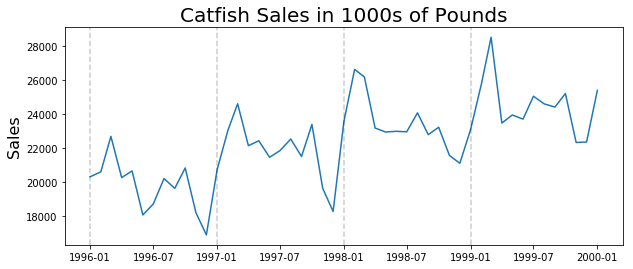

In [6]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [7]:
first_diff = lim_catfish_sales.diff()[1:]

In [8]:
def adfuller_test(sales):
    result= adfuller(sales)
    labels = ["ADF Test Statistics","p-value","#Lags Used","Number of Observations Used"]
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

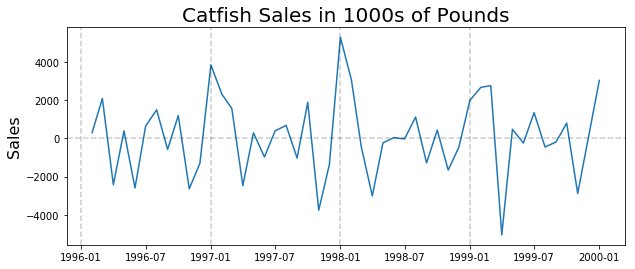

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

In [10]:
adfuller_test(first_diff)

ADF Test Statistics : -9.515038694170041
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
p-value : 3.173838700626354e-16
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
#Lags Used : 10
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
Number of Observations Used : 37
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<BarContainer object of 17 artists>

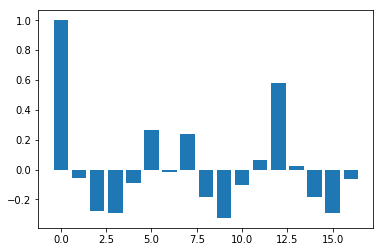

In [11]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

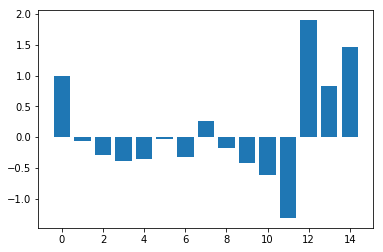

In [12]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [13]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

In [14]:
my_order = (2,1,2)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [15]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Model Fitting Time: 0.5390310287475586


C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [16]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -364.584
Date:                              Sat, 10 Sep 2022   AIC                            743.167
Time:                                      01:00:37   BIC                            755.331
Sample:                                  01-01-1996   HQIC                           747.626
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7593      0.127     13.891      0.000       1.511       2.008
ar.L2         -0.77

In [17]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
predictions

Date
1999-08-01    25279.063971
1999-09-01    24263.499634
1999-10-01    24531.848860
1999-11-01    22681.733166
1999-12-01    21793.473357
2000-01-01    24587.212531
Freq: MS, Name: predicted_mean, dtype: float64

Text(0, 0.5, 'Error')

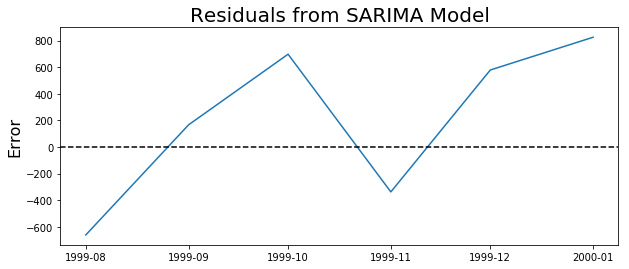

In [18]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

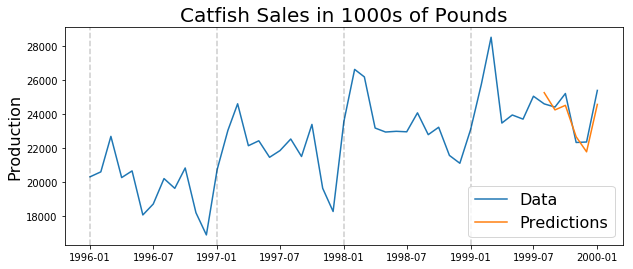

In [19]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0225


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 588.7527487738436


In [22]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred
print(rolling_predictions)

C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-statio

Date
1999-08-01    25279
1999-09-01    23965
1999-10-01    25247
1999-11-01    23800
1999-12-01    21778
2000-01-01    25238
Freq: MS, Name: Total, dtype: int64


C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [23]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

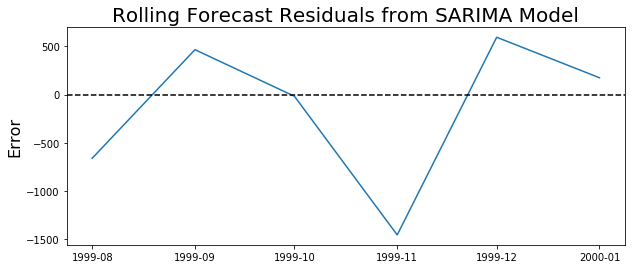

In [24]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

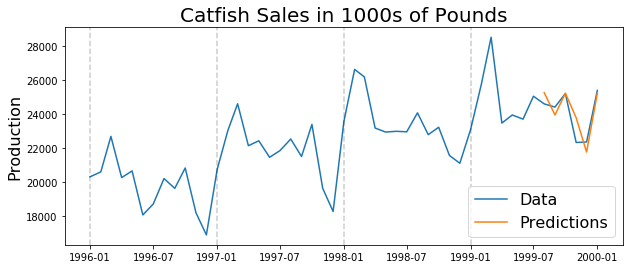

In [25]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [26]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0242


In [27]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 725.3180911388695
